### Прогнозирование возраста морского ушка на основе физических измерений.

Возраст морского ушка определяется путем разрезания оболочки через конус, ее окрашивания и подсчета количества колец через микроскоп - скучная и трудоемкая задача.  Другие измерения, которые легче получить, используются для прогнозирования возраста.  Для решения этой задачи может потребоваться дополнительная информация, например, о погодных условиях и местоположении (отсюда и наличие продовольствия).


Дано имя атрибута, тип атрибута, единица измерения и
краткое описание. Количество колец - это значение для прогнозирования: либо
как непрерывное значение или как проблема классификации.

| Название | Тип данных | Измер. | Описание |
|---------|----------|------------|----|
| Пол | именной | - | M, F и I (младенец)
| Длина | непрерывная | мм. | Самое длинное измерение раковины
| Диаметр | непрерывного | мм. | перпендикулярно длине
| Высота | непрерывного | мм. | с мясом в скорлупе
| Общий вес | непрерывного | граммы | всего ушка
| Перемешанный вес | непрерывного | граммы | веса мяса
| Вес внутренностей | непрерывный | граммы | веса кишечника (после кровотечения)
| Вес скорлупы | непрерывный | граммы  | после сушки
| Кольца | целые | - | +1,5 дает возраст в годах

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# from sklearn import курсач
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.svm import SVC, SVR, LinearSVR, NuSVR
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn.ensemble import *
from sklearn.neural_network import MLPRegressor
from sklearn.tree import *
from sklearn.neighbors import KNeighborsRegressor
from sklearn.kernel_ridge import KernelRidge

import pickle

import tensorflow as tf
import tensorflow.keras as keras

import itertools
from datetime import datetime
import os

ModuleNotFoundError: No module named 'keras'

In [4]:
from util_funcs import *

ModuleNotFoundError: No module named 'keras'

In [20]:
data_path = './data/abalone.csv'
df = pd.read_csv(data_path)

In [6]:
df.head()

Sex  Length  Diameter  Height   Whole  Shucked  Viscera  Shell  Rings
0   M   0.455     0.365   0.095  0.5140   0.2245   0.1010  0.150     15
1   M   0.350     0.265   0.090  0.2255   0.0995   0.0485  0.070      7
2   F   0.530     0.420   0.135  0.6770   0.2565   0.1415  0.210      9
3   M   0.440     0.365   0.125  0.5160   0.2155   0.1140  0.155     10
4   I   0.330     0.255   0.080  0.2050   0.0895   0.0395  0.055      7

In [11]:
def show_boxplot(df):
    l = df.loc[:, 'Length':].columns.values
    number_of_columns=9
    number_of_rows = len(l)-1/number_of_columns
    plt.figure(figsize=(number_of_columns,5*number_of_rows))
    for i in range(0,len(l)):
        plt.subplot(number_of_rows + 1,number_of_columns,i+1)
        sns.set_style('whitegrid')
        sns.boxplot(df[l[i]],color='green',orient='v')
        plt.tight_layout()

In [12]:
show_boxplot(df)

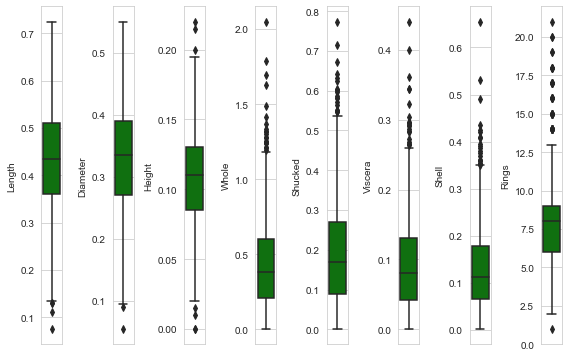

In [13]:
show_boxplot(df[df.Sex == 'I'])

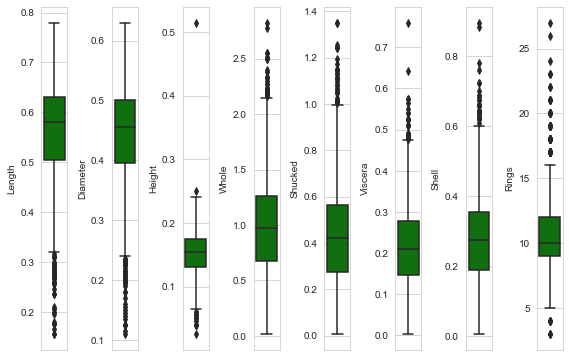

In [14]:
show_boxplot(df[df.Sex == 'M'])

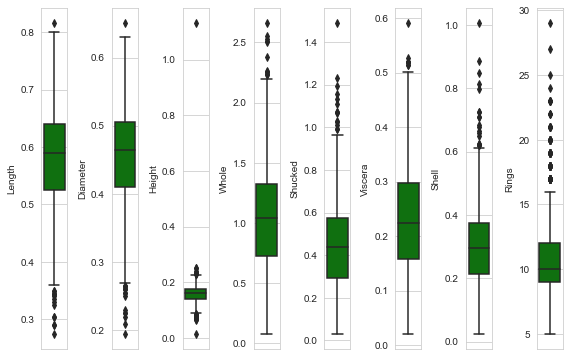

In [15]:
show_boxplot(df[df.Sex == 'F'])

Размеры самок обычно наибольшие в популяции, далее за ними идут самцы (тк им нет необходимости создавать потомство), после самцов меньше обычно подрастающее поколение.

Далее на основе интуитивных соображений.

Преобразуем класс Пол в числовое значение (грубый аналог веса). Веса подбирались эксперементально, пытаясь достичь наибольшей кореляции пола к другим параметрам.

In [64]:
# Данные можно не загружать заново, просто мне так было проще эксперементировать с числовыми коэфициентами
df = pd.read_csv(data_path)
df.Sex = df.Sex.transform(lambda x:{"M": 0.8,"F": 1,"I": 0}[x])

In [22]:
df.head()

Sex  Length  Diameter  Height   Whole  Shucked  Viscera  Shell  Rings
0  0.6   0.455     0.365   0.095  0.5140   0.2245   0.1010  0.150     15
1  0.6   0.350     0.265   0.090  0.2255   0.0995   0.0485  0.070      7
2  1.0   0.530     0.420   0.135  0.6770   0.2565   0.1415  0.210      9
3  0.6   0.440     0.365   0.125  0.5160   0.2155   0.1140  0.155     10
4  0.0   0.330     0.255   0.080  0.2050   0.0895   0.0395  0.055      7

In [63]:
corrmat = df.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True, annot=True)

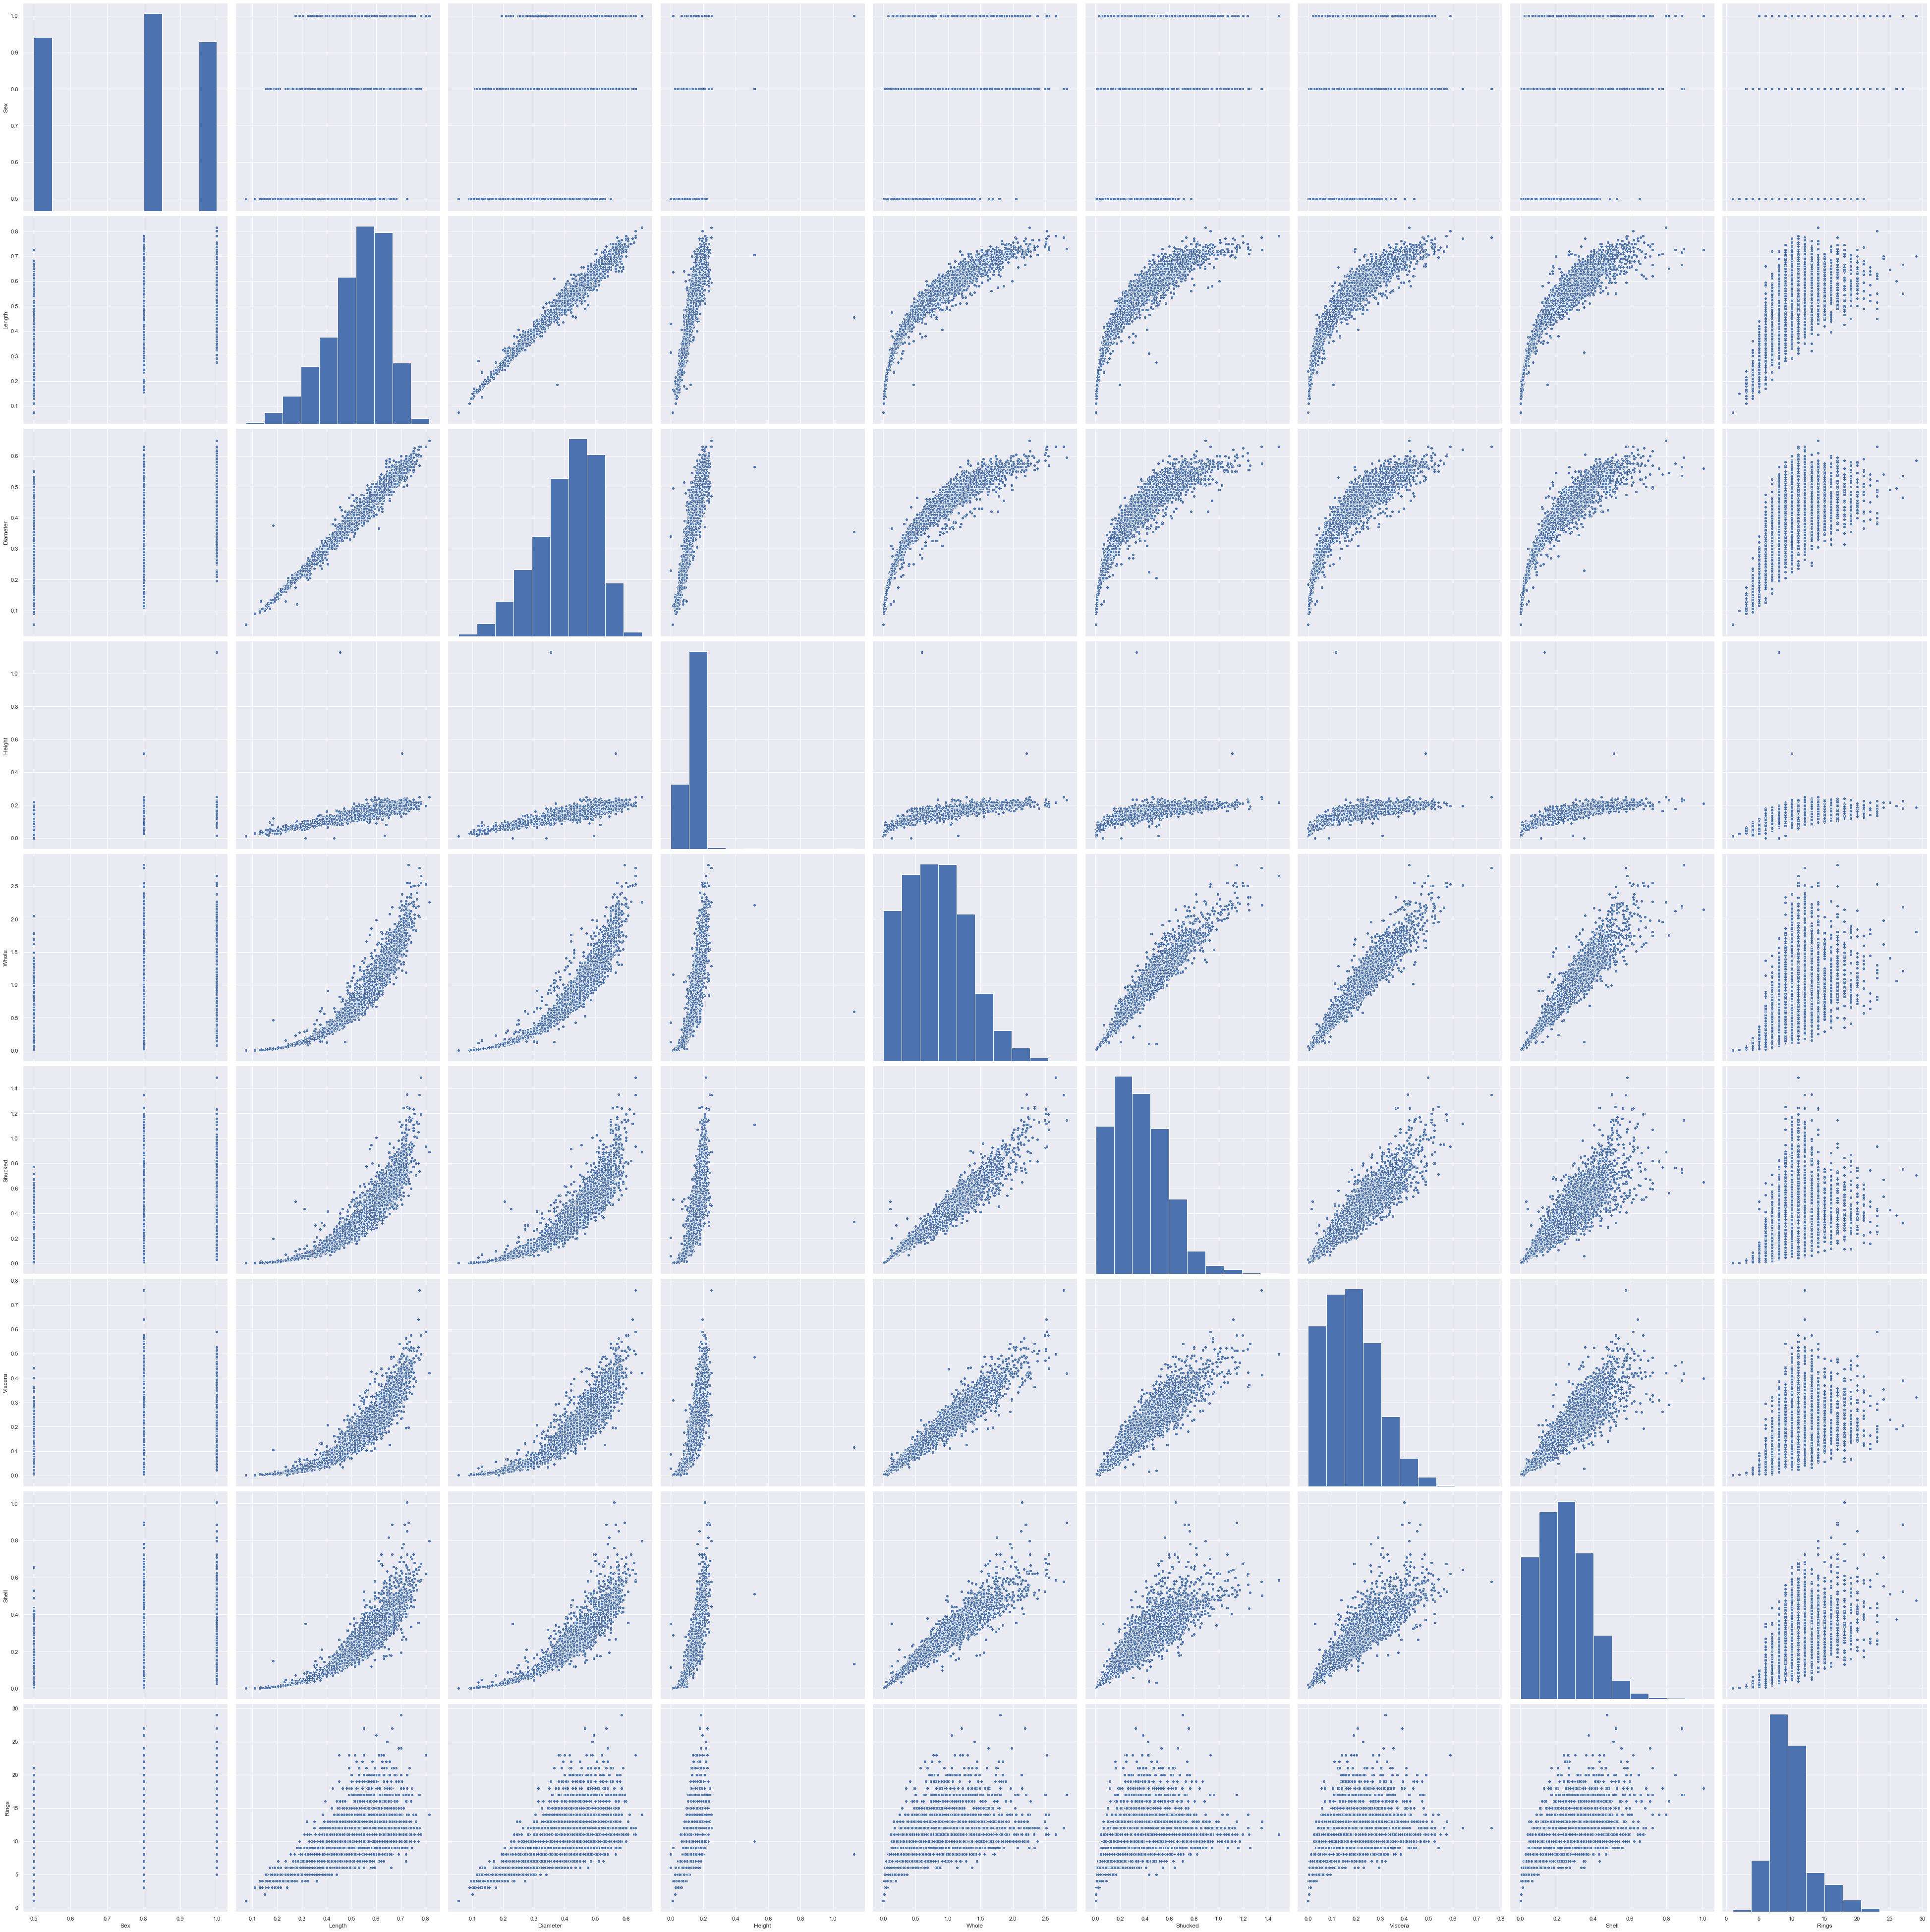

In [51]:
sns.set()
sns.pairplot(df, height = 6)
plt.show();

(картинка генерится качественная нужно просто просмотреть не через ноутбук)

Из графиков выше видно что между почти всеми параметрами прослеживается кореляция. Так же оказалась верна наша догадка насчет пола и их числовых эквивалентов.

Попробуем избавить данные от избыточности.

1. Диаметр, тк линейно зависит от длины
2. Высота, тк линейно зависит от длины

От остальных данных мы избавляться не будет тк это может напрямую повредить точности далнейших моделей.

In [65]:
# мы пробовали не избавляться, результат выходит хуже
df.drop(['Diameter', 'Height'], axis=1, inplace=True)

In [66]:
sns.set()
sns.pairplot(df, height = 6)
plt.show();

In [67]:
X_data, Y_data = df.loc[:,:"Shell"], df["Rings"]

X_train,  X_test,  y_train,  y_test =  train_test_split(X_data, Y_data,  test_size= 0.20,  random_state= 42 )
splited_data = [X_train, y_train, X_test, y_test]

# данные, дополненные полиномами
poly = PolynomialFeatures(degree = 2)
poly_splited_data = [poly.fit_transform(X_train), y_train, poly.transform(X_test), y_test]

# нормализованные данные
scaler = StandardScaler()
scaler.fit(X_train)
norm_X_train = scaler.transform(X_train)
norm_X_test = scaler.transform(X_test)
norm_splited_data = [norm_X_train, y_train, norm_X_test, y_test]

Попробуем визуализировать исходные данные и предсказания лучших моделей на них:

In [68]:
# здесь должна быть загрузка данных

In [69]:
showG(X_data, model)

NameError: name 'showG' is not defined

In [ ]:
model_bagging_1layerperc = BaggingRegressor(base_estimator= MLPRegressor(hidden_layer_sizes=(10,), solver='lbfgs', random_state=42), n_estimators=30, random_state=42)
model_bagging_1layerperc.fit(X_train, y_train)
showG(X_data, model_bagging_1layerperc)